# Predicciones del mercado de valores con LSTM en Python

Redes de memoria a largo plazo (LSTM) en Python y cómo puede usarlas para hacer predicciones del mercado de valores.


https://www.datacamp.com/tutorial/lstm-python-stock-market
https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

En este tutorial, verá cómo puede utilizar un modelo de series temporales conocido como memoria larga a corto plazo. Los modelos LSTM son potentes, especialmente para conservar la memoria a largo plazo, por diseño, como verá más adelante.

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

# from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import tensorflow as tf # This code has been tested with TensorFlow 1.6

In [3]:
def min_max_scaler(data, min_val, max_val, feature_range=(0, 1)):
    """
    Escala los datos al rango especificado utilizando Min-Max Scaling.

    Args:
    data (list): La lista de valores a escalar.
    feature_range (tuple): El rango objetivo del escalado, por defecto (0, 1).

    Returns:
    list: Lista de valores escalados.
    """
  #  min_val = min(data)
  #  max_val = max(data)
    min_range, max_range = feature_range
    scaled_data = [(x - min_val) / (max_val - min_val) * (max_range - min_range) + min_range for x in data]
    return scaled_data



In [7]:
# Ejemplo de uso
data = [1, 2, 3, 4, 5]
min_val = min(data)
max_val = max(data)
scaled_data = min_max_scaler(data, min_val, max_val , (-1,1))
print(scaled_data)

print(min_val, max_val)

[-1.0, -0.5, 0.0, 0.5, 1.0]
1 5


In [6]:
def inverse_min_max_scaler(scaled_data, min_val, max_val, feature_range=(0, 1)):
    """
    Revierte el escalado Min-Max y obtiene los valores originales.

    Args:
    scaled_data (list): La lista de valores escalados.
    min_val: El valor mínimo original antes del escalado.
    max_val: El valor máximo original antes del escalado.
    feature_range (tuple): El rango objetivo del escalado, por defecto (0, 1).

    Returns:
    list: Lista de valores originales.
    """
    min_range, max_range = feature_range
    original_data = [(x - min_range) / (max_range - min_range) * (max_val - min_val) + min_val for x in scaled_data]
    return original_data


In [8]:
# Escalas los datos originales
#scaled_data = min_max_scaler(original_data)

# Revierte el escalado para obtener los valores originales
original_data = inverse_min_max_scaler(scaled_data, min_val, max_val, (-1,1))
print(original_data)

[1.0, 2.0, 3.0, 4.0, 5.0]


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
ferrari = '/content/drive/MyDrive/Colab Notebooks/Curso NN/RACE.csv'

In [ ]:
# Date,Open,High,Low,Close

In [16]:
# ! more '/content/drive/MyDrive/Colab Notebooks/Curso NN/RACE.csv'

In [14]:
df = pd.read_csv(ferrari)

In [20]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,2018-11-05,116.419998,118.779999,115.809998,117.580002
1,2018-11-06,115.470001,116.370003,114.869003,115.989998
2,2018-11-07,115.940002,116.930000,115.639999,116.070000
3,2018-11-08,115.949997,116.709999,113.589996,114.199997
4,2018-11-09,111.750000,112.360001,108.831001,110.070000


In [22]:
# print(df['Low'])

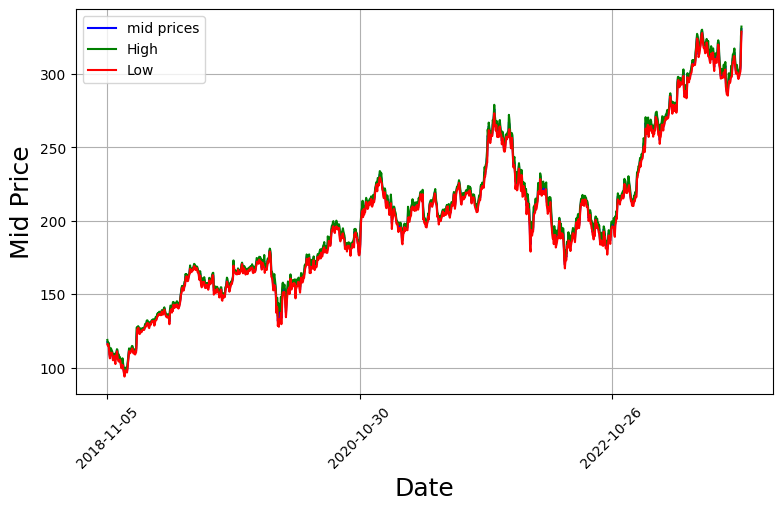

In [23]:
plt.figure(figsize = (9,5))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0, c = 'b', label = 'mid prices')
plt.plot(range(df.shape[0]),df['High'], c='green', label = 'High')
plt.plot(range(df.shape[0]),df['Low'], c='red', label = 'Low')
#plt.plot(range(df.shape[0]),df['Open'], c='green', label = 'Open')
#plt.plot(range(df.shape[0]),df['Close'], c='r', label = 'Close')
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.grid()
plt.legend()
plt.show()

In [24]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [25]:
print(len(mid_prices))
large = round(len(mid_prices) * 0.8) # It mean 80 %
print(large)

1258
1006


In [26]:
# here we divide the total data frame in train_data (80 %) and test_data (20 %)
train_data = mid_prices[:large]
test_data = mid_prices[large:]

### Normalizando los datos

Ahora necesita definir un escalador para normalizar los datos. MinMaxScalarescala todos los datos para que estén en la región de 0 y 1. También puede remodelar los datos de entrenamiento y prueba para que tengan la forma [data_size, num_features].

In [27]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
min_val = min(mid_prices)
max_val = max(mid_prices)
print(min_val,max_val )
train_data_scaled = min_max_scaler(train_data, min_val, max_val, (-1,1))
test_data_scaled = min_max_scaler(test_data, min_val, max_val, (-1,1))

96.11000061035156 330.24745178222656


In [28]:
# train_data_scaled
print(len(train_data_scaled))
print(len(test_data_scaled))

1006
252




En este proyecto, utilizamos 60 n_steps. También podemos reducir o aumentar el número de pasos para optimizar el rendimiento del modelo.

In [29]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [30]:
n_steps = 60
features = 1
# split into samples
Xx_train, y_train = split_sequence(train_data_scaled, n_steps)
Xx_test, y_test = split_sequence(test_data_scaled, n_steps)

In [ ]:
# print(Xx_test)

In [31]:
# Reshaping X_train for model
X_train = Xx_train.reshape(Xx_train.shape[0],Xx_train.shape[1],features)
X_test = Xx_test.reshape(Xx_test.shape[0],Xx_test.shape[1],features)

In [33]:
# print(X_train)

Modelo LSTM

El modelo consta de una única capa oculta de LSTM y una capa de salida. Puedes experimentar con la cantidad de unidades, ya que más unidades te darán mejores resultados. Para este experimento, estableceremos las unidades LSTM en 125, tanh como activación y estableceremos el tamaño de entrada.

Finalmente, compilaremos el modelo con un optimizador RMSprop y un error cuadrático medio como función de pérdida.

In [34]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El modelo se entrenará en 50 épocas con 32 tamaños de lote. Puedes cambiar los hiperparámetros para reducir el tiempo de entrenamiento o mejorar los resultados. El entrenamiento del modelo se completó con éxito con la mejor pérdida posible.

In [35]:
%%time
result_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

CPU times: user 2min 37s, sys: 7.9 s, total: 2min 45s
Wall time: 2min 15s


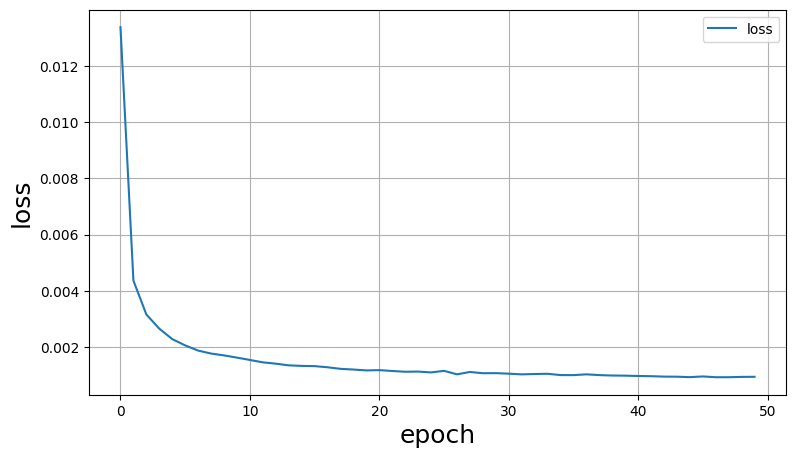

In [36]:
plt.figure(figsize = (9,5))
plt.plot(result_lstm.history['loss'], label ='loss')
plt.xlabel('epoch',fontsize=18)
plt.ylabel('loss',fontsize=18)
plt.grid()
plt.legend()
plt.show()

Resultados

Vamos a repetir el preprocesamiento y normalizar el conjunto de prueba. En primer lugar, transformaremos y luego dividiremos el conjunto de datos en muestras, le remodelaremos, predeciremos y transformaremos inversamente las predicciones a la forma estándar.

In [37]:
# predicted_stock_price scaled
predicted_stock_price_lstm = model_lstm.predict(X_test)
#inverse transform the values, unescaled
predicted_stock_price_lstm_unscaled = inverse_min_max_scaler(predicted_stock_price_lstm, min_val, max_val, (-1,1))

6/6 [==============================] - 1s 30ms/step


In [39]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Ferrari Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Ferrari Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(tf.keras.losses.mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse[0]))



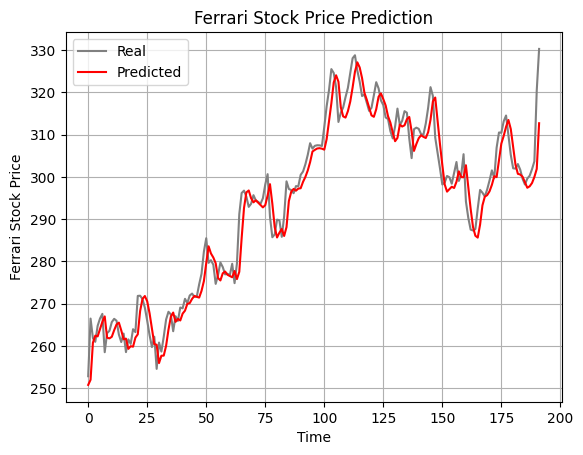

In [40]:
real_stock_price = inverse_min_max_scaler(y_test, min_val, max_val, (-1,1))
plot_predictions(real_stock_price, predicted_stock_price_lstm_unscaled)


In [41]:
return_rmse(real_stock_price, predicted_stock_price_lstm)


The root mean squared error is 293.86.


Modelo GRU

Mantendremos todo igual y simplemente reemplazaremos la capa LSTM con la capa GRU para comparar adecuadamente los resultados. La estructura del modelo contiene una única capa GRU con 125 unidades y una capa de salida.

Las capas GRU (Gated Recurrent Unit) son un tipo de capa recurrente en redes neuronales recurrentes (RNNs) que se utilizan comúnmente para modelar secuencias en el aprendizaje profundo.

Las GRUs son una variante de las redes LSTM (Long Short-Term Memory) y están diseñadas para manejar problemas de desvanecimiento del gradiente y la preservación a largo plazo de la información en secuencias.

Aquí hay una descripción de las partes clave de una capa GRU:

> Actualización de puerta (Update Gate): Decide cuánta información pasada debe olvidarse y cuánta información nueva debe almacenarse.

> Reinicio de puerta (Reset Gate): Decide cómo combinar la nueva entrada con la memoria pasada.

> Hidden State (Estado Oculto): Almacena la información actual y la transfiere a la siguiente etapa de la secuencia.

Una capa GRU tiene menos parámetros que una capa LSTM, lo que puede hacer que sea más rápida de entrenar y utilizar en ciertos casos.

Aquí hay un ejemplo de cómo se puede utilizar una capa GRU en TensorFlow y Keras:

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(10, 16)))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=128))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```
En este ejemplo:

* **units** es la dimensión de salida de la capa GRU.
* **return_sequences** indica si se deben devolver secuencias completas o solo la última salida.
* **input_shape** es la forma de los datos de entrada a la red.

La capa GRU se puede apilar (usando **return_sequences=True**) para crear capas recurrentes más profundas y complejas si se necesita modelar datos secuenciales más complejos.


In [42]:

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
%%time
result_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

CPU times: user 2min 5s, sys: 3.96 s, total: 2min 9s
Wall time: 1min 33s


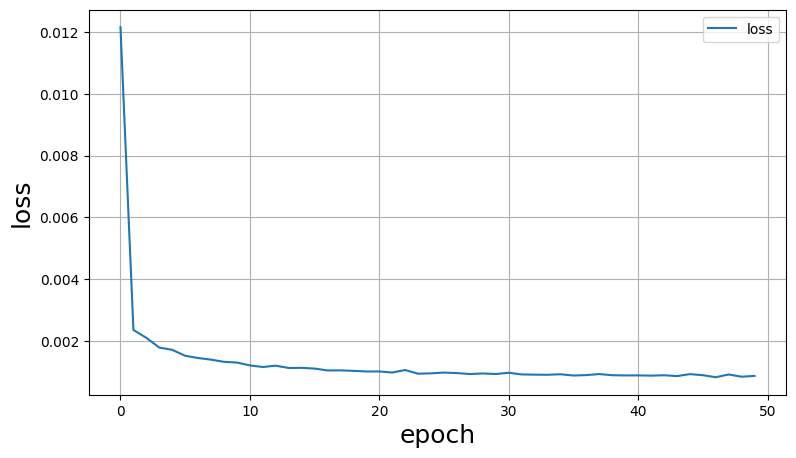

In [45]:
plt.figure(figsize = (9,5))
plt.plot(result_gru.history['loss'], label ='loss')
plt.xlabel('epoch',fontsize=18)
plt.ylabel('loss',fontsize=18)
plt.grid()
plt.legend()
plt.show()

In [46]:
# predicted_stock_price scaled
predicted_stock_price_gru = model_gru.predict(X_test)
#inverse transform the values, unescaled
predicted_stock_price_gru_unscaled = inverse_min_max_scaler(predicted_stock_price_gru, min_val, max_val, (-1,1))

6/6 [==============================] - 0s 16ms/step


In [47]:
return_rmse(real_stock_price, predicted_stock_price_gru_unscaled)

The root mean squared error is 48.00.


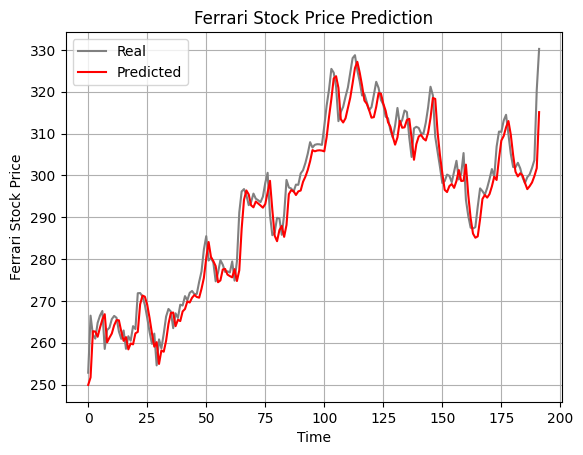

In [48]:
plot_predictions(real_stock_price, predicted_stock_price_gru_unscaled)

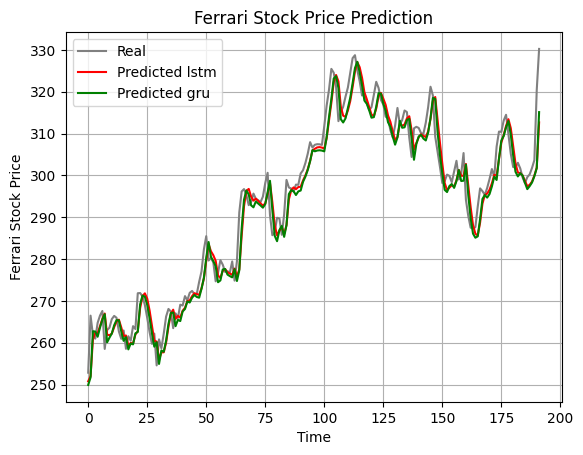

In [49]:
plt.plot(real_stock_price, color="gray", label="Real")
plt.plot(predicted_stock_price_lstm_unscaled, color="red", label="Predicted lstm")
plt.plot(predicted_stock_price_gru_unscaled, color="green", label="Predicted gru")
plt.title("Ferrari Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Ferrari Stock Price")
plt.legend()
plt.grid()
plt.show()
